In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import numpy as np 
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
sns.set()

In [4]:
# class parameters adapted from code in class session 4.2_preclass
class TrafficSimulation:
    def __init__(self, length = 100, density = 0.5, v_max = 5, slow_down_prob= 0.5):

        self.length = length#length (int) The number of cells in the road. Default: 100.
        self.density = density#car_density (float) The fraction of cells that have a car on them  Default: 0.2.
             
        self.v_max = v_max#max_speed (int) The maximum speed in car cells per update step.Default: 5.
        self.slow_down_prob = slow_down_prob#low_down_prob (float) The probability that a car will randomly
              #slow down by 1 during an update step. Default: 0.5.
    
        self.state = [v_max if i <= length*density else -1 for i in range(length)]
        np.random.shuffle(self.state)  
    def calculate_distance_and_velocity(self):
        for i, s in enumerate(self.state):
            if s >= 0:
                distance = 1
                # find distance to next car
                while self.state[(i + distance) % self.length] == -1: distance+= 1
                
                # accelerate if distance to next car greater than velocity. 
                # If less, slow down to distance-1
                self.state[i] = min(self.state[i] + 1, self.v_max) if distance> s + 1 else (distance-1)
                
                # decrease speed by 1 with probability slow_down_prob 
                if (self.state[i] > 0 and np.random.random() < self.slow_down_prob): self.state[i] -= 1
                   
    def update_rule(self):
        new_state = [-1] * self.length

        for k, v in enumerate(self.state):
            if v >= 0: 
                new_state[(k + v) % self.length] = v
        
        self.state = new_state
        
    def run_update_rule_and_calculate_distance_and_velocity(self, n, verbose = False):
        for _ in range(n):
            self.calculate_distance_and_velocity()
            if verbose: 
                self.display()
            self.update_rule()
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state))

In [5]:
if __name__ == '__main__':
    np.random.seed(20)
    traffic = TrafficSimulation(length = 100, density = 0.03, v_max = 5,  slow_down_prob= 0.5)
    traffic.run_update_rule_and_calculate_distance_and_velocity(20, verbose = True)

..5.....4.................4..............................................5..........................
.......3....5.................4...............................................5.....................
..........3......5................4................................................5................
.............4........5...............4.................................................5...........
.................5.........4..............5..................................................5......
......................5........5...............5..................................................4.
..5........................5........5...............4...............................................
.......4........................4........4..............4...........................................
...........4........................5........5..............5.......................................
...............4.........................4........4..............4.........................

In [6]:
if __name__ == '__main__':
    np.random.seed(69)
    traffic = TrafficSimulation(length = 100, density = 0.1, v_max = 5, slow_down_prob = 0.5)
    traffic.run_update_rule_and_calculate_distance_and_velocity(20, verbose = True)

.....4......4.........3...5.....4.....04......5................................2...5.......5........
.........4......5........4.....4....0.1....5.......4.............................2......4.......5...
.4...........5.......5.......4.....00..1........5......4...........................3........4.......
.....5............4.......4......1.00...2............4.....4..........................3.........5...
.5........5...........5.......2...001.....3..............4.....4.........................3..........
......5........4...........3....1.01.2.......4...............5.....5........................4.......
...........4.......4..........1..00.2..2.........4................5.....4.......................5...
.4.............4.......4.......0.01...2..2...........5.................3....5.......................
.....5.............5.......2...1.1.1....2..3..............5...............4......4..................
..........5.............4....2..0.0.2.....3...4................5..............5......4.....

In [7]:
class Flow_sim(TrafficSimulation):
    def update(self):
        new_state =-np.ones(self.length, dtype=int)
        
        flow_of_car = 0

        for i, s in enumerate(self.state):
            if s >= 0: 
                new_state[(i + s) % self.length] = s
            if i + s > self.length:
                
                flow_of_car += 1
        
        self.state = new_state
        
        return flow_of_car
        
    def compile_and_display(self, n, verbose = False):
        f = []
        for _ in range(n):
            self.calculate_distance_and_velocity()
            if verbose: 
                self.display()
            f.append(self.update())
        return np.mean(f)

Text(0, 0.5, 'Flow')

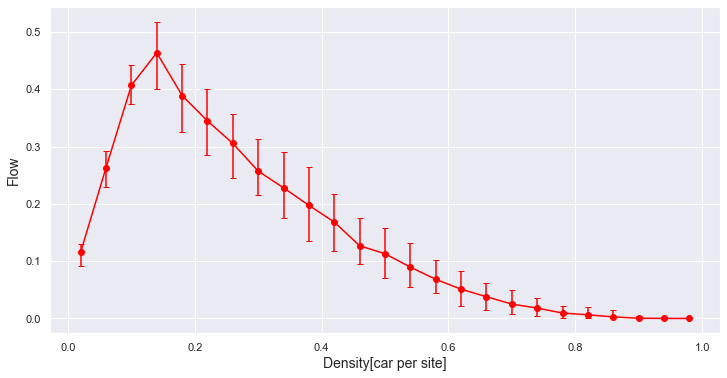

In [8]:
densities = np.arange(0.02, 1, 0.04)#define density with mean 0.02 nad standard deviation 1
densities=densities.repeat(100)
flow = [Flow_sim(100, s, 5, .2).compile_and_display(n=200) for s in densities]
plt.figure(figsize=(12,6))

plt.errorbar(np.arange(0.02, 1, 0.04),  np.mean(np.reshape(flow, (-1,100)), axis = 1),
             yerr = np.abs(np.mean(np.reshape(flow, (-1,100)), axis = 1) - 
                           np.percentile(np.reshape(flow, (-1,100)), [2.5,97.5], axis = 1)),
            fmt = '-o', capsize = 3, color="red")

plt.xlabel('Density[car per site]', fontsize = 14)
plt.ylabel('Flow', fontsize = 14)